#SECTION 1

 The goal of this assignment is to learn about experiment tracking, version control, and reproducibility in machine learning workflows. You will set up experiment tracking using Weights and Biases.

In [1]:
!pip install wandb

^C


### **Some necessary libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import wandb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### **Weights and Biases and train_test_split**

In [ ]:
wandb.init(project="mlp-iris-tracking", name="MLP_Iris_Experiment")

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

### **Implement a Multi-Layer Perceptron (MLP) Using the Iris Dataset**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Train the MLP Model**

In [ ]:
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

### **Plot training and validation loss curves over epochs using Matplotlib**

In [ ]:
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
wandb.log({"loss_curve": wandb.Image(plt)})

### **metrics using the test set**

In [ ]:
model.eval()
y_pred_list, y_true_list = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
        y_true_list.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

accuracy = accuracy_score(y_true_list, y_pred_list)
precision = precision_score(y_true_list, y_pred_list, average="weighted")
recall = recall_score(y_true_list, y_pred_list, average="weighted")
f1 = f1_score(y_true_list, y_pred_list, average="weighted")
cm = confusion_matrix(y_true_list, y_pred_list)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})

### **Plots**

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.target_names, yticklabels=dataset.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
wandb.log({"confusion_matrix": wandb.Image(plt)})

### **SECTION 2**

This section aims to perform a hyperparameter search to improve the performance of a custom model that distinguishes between any three classes.

```
# This is formatted as code
```




### **Task 1**


Hyperparameter Optimization

In [ ]:
import itertools
import pandas as pd

### **Train the model on the batch size of [2 & 4], learning rate [1e-3 and 1e-5], and epochs [1, 3, and 5]**

In [ ]:
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

results = []

### **Train the model and measure the accuracy and F1 over the test set. Plot the confusion matrix over the test-set predictions.**


Training Model with Batch Size=2, LR=0.001, Epochs=1
Accuracy: 0.6333, F1-score: 0.5831


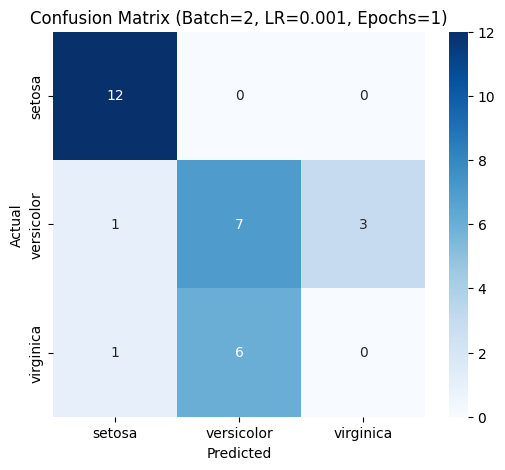


Training Model with Batch Size=2, LR=0.001, Epochs=3
Accuracy: 0.7000, F1-score: 0.6376


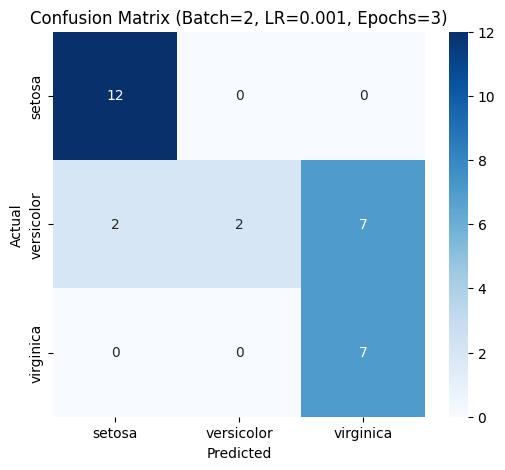


Training Model with Batch Size=2, LR=0.001, Epochs=5
Accuracy: 0.7667, F1-score: 0.7511


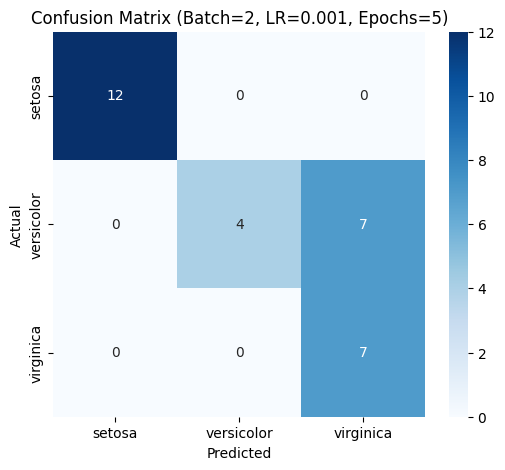


Training Model with Batch Size=2, LR=1e-05, Epochs=1
Accuracy: 0.4667, F1-score: 0.3723


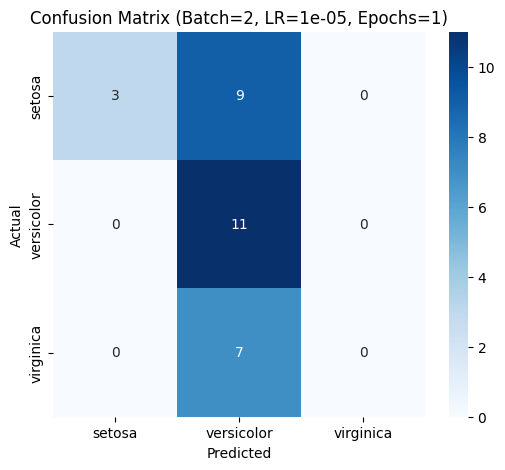


Training Model with Batch Size=2, LR=1e-05, Epochs=3
Accuracy: 0.7000, F1-score: 0.7134


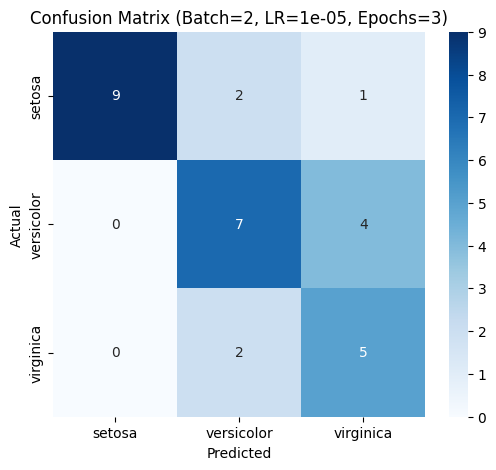


Training Model with Batch Size=2, LR=1e-05, Epochs=5
Accuracy: 0.3667, F1-score: 0.2180


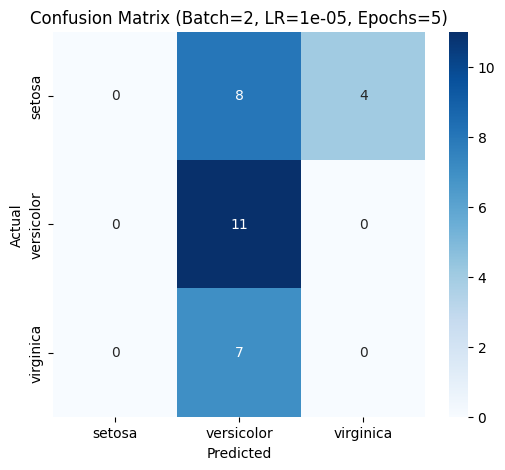


Training Model with Batch Size=4, LR=0.001, Epochs=1
Accuracy: 0.2333, F1-score: 0.0883


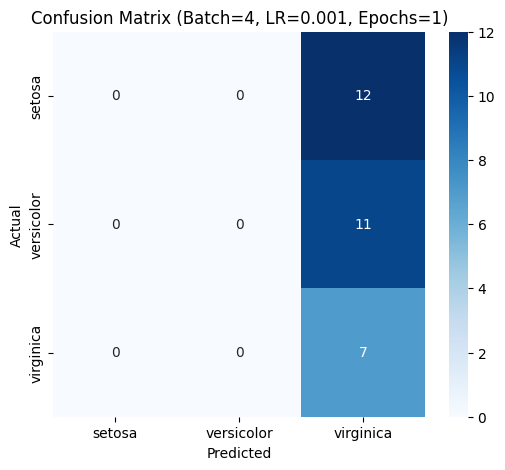


Training Model with Batch Size=4, LR=0.001, Epochs=3
Accuracy: 0.6000, F1-score: 0.4743


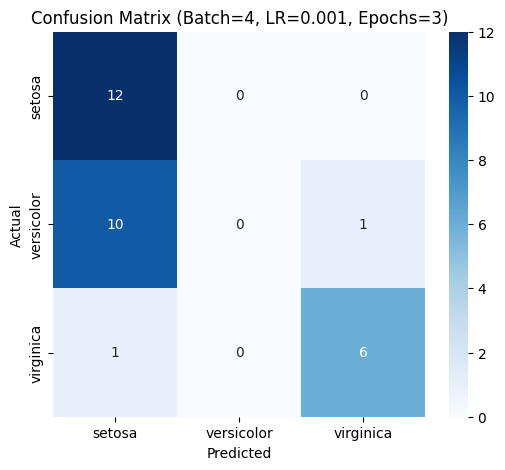


Training Model with Batch Size=4, LR=0.001, Epochs=5
Accuracy: 0.8000, F1-score: 0.7925


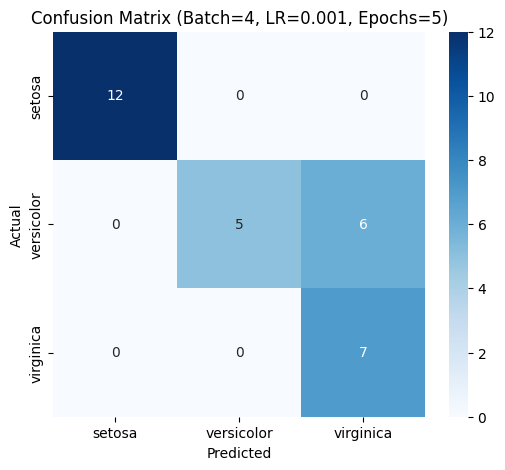


Training Model with Batch Size=4, LR=1e-05, Epochs=1
Accuracy: 0.6333, F1-score: 0.5307


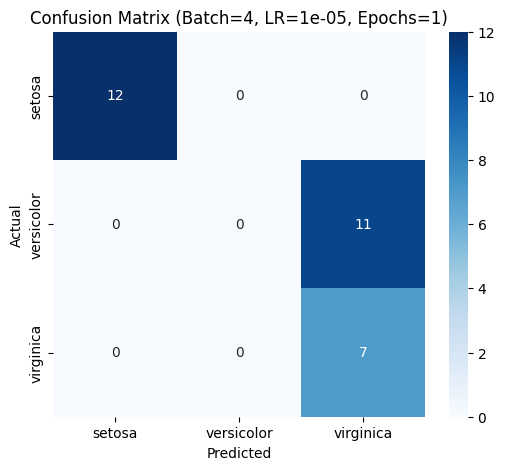


Training Model with Batch Size=4, LR=1e-05, Epochs=3
Accuracy: 0.0333, F1-score: 0.0489


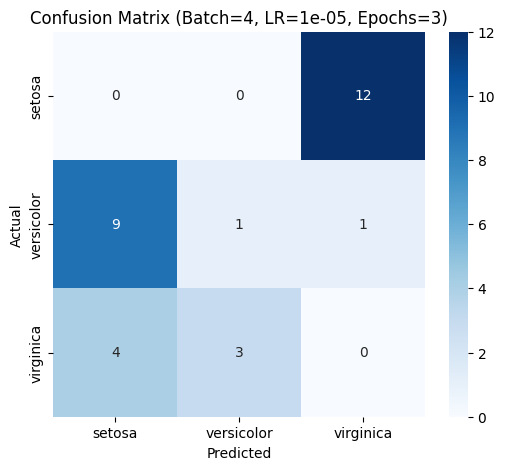


Training Model with Batch Size=4, LR=1e-05, Epochs=5
Accuracy: 0.6333, F1-score: 0.5040


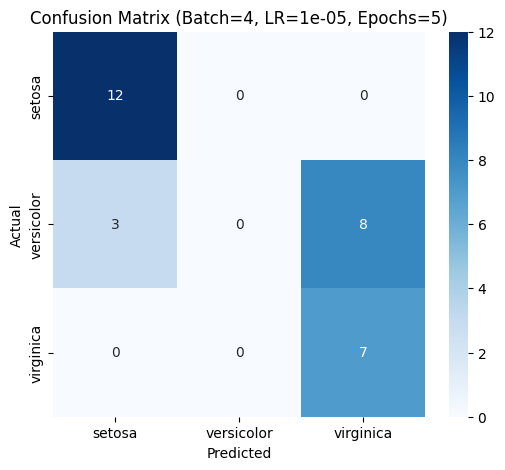

In [ ]:
for batch_size, lr, epochs in itertools.product(batch_sizes, learning_rates, epochs_list):
    print(f"\nTraining Model with Batch Size={batch_size}, LR={lr}, Epochs={epochs}")

    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred_list, y_true_list = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            y_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
            y_true_list.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    accuracy = accuracy_score(y_true_list, y_pred_list)
    f1 = f1_score(y_true_list, y_pred_list, average="weighted")
    cm = confusion_matrix(y_true_list, y_pred_list)

    print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

    results.append({
        "Batch Size": batch_size,
        "Learning Rate": lr,
        "Epochs": epochs,
        "Accuracy": accuracy,
        "F1 Score": f1
    })

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.target_names, yticklabels=dataset.target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Batch={batch_size}, LR={lr}, Epochs={epochs})")
    plt.show()


### **Some results values**

In [ ]:
df_results = pd.DataFrame(results)
print("\nFinal Results:\n", df_results)


Final Results:
     Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.633333  0.583120
1            2        0.00100       3  0.700000  0.637607
2            2        0.00100       5  0.766667  0.751111
3            2        0.00001       1  0.466667  0.372281
4            2        0.00001       3  0.700000  0.713445
5            2        0.00001       5  0.366667  0.218018
6            4        0.00100       1  0.233333  0.088288
7            4        0.00100       3  0.600000  0.474286
8            4        0.00100       5  0.800000  0.792500
9            4        0.00001       1  0.633333  0.530667
10           4        0.00001       3  0.033333  0.048889
11           4        0.00001       5  0.633333  0.504040


### **Show the inputs, prediction, and truth values for five samples from the test set.**

In [ ]:
print("\nSample Predictions:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[sample_indices], y_test[sample_indices]

with torch.no_grad():
    y_pred_sample = model(X_sample)
    y_pred_sample = torch.argmax(y_pred_sample, dim=1).cpu().numpy()
    y_true_sample = torch.argmax(y_sample, dim=1).cpu().numpy()

for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Input: {X_sample[i].numpy()}")
    print(f"  Prediction: {dataset.target_names[y_pred_sample[i]]}")
    print(f"  Truth: {dataset.target_names[y_true_sample[i]]}\n")


Sample Predictions:
Sample 1:
  Input: [-1.4986345  1.4163153 -1.675566  -1.4056851]
  Prediction: setosa
  Truth: setosa

Sample 2:
  Input: [-0.05167705 -0.74242336  0.01723376 -0.05282593]
  Prediction: setosa
  Truth: versicolor

Sample 3:
  Input: [-1.2574749   0.93659556 -1.3253316  -1.4056851 ]
  Prediction: setosa
  Truth: setosa

Sample 4:
  Input: [ 1.033541   -0.02284379  0.776075    1.4353192 ]
  Prediction: virginica
  Truth: virginica

Sample 5:
  Input: [-0.7751557  1.1764554 -1.383704  -1.4056851]
  Prediction: setosa
  Truth: setosa



# **Task 2**

Automated Hyperparameter Search

In [ ]:
!pip install --upgrade --no-cache-dir autogluon

In [ ]:
!pip show autogluon

Name: autogluon
Version: 1.2
Summary: Fast and Accurate ML in 3 Lines of Code
Home-page: https://github.com/autogluon/autogluon
Author: AutoGluon Community
Author-email: 
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: autogluon.core, autogluon.features, autogluon.multimodal, autogluon.tabular, autogluon.timeseries
Required-by: 


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

### **Dataset**

In [ ]:
X_train_np = X_train.numpy()
y_train_np = np.argmax(y_train.numpy(), axis=1)  # Convert one-hot to labels
X_test_np = X_test.numpy()
y_test_np = np.argmax(y_test.numpy(), axis=1)

train_df = pd.DataFrame(X_train_np, columns=[f'feature_{i}' for i in range(X_train_np.shape[1])])
train_df['target'] = y_train_np

test_df = pd.DataFrame(X_test_np, columns=[f'feature_{i}' for i in range(X_test_np.shape[1])])
test_df['target'] = y_test_np

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['target'])

In [ ]:
import autogluon.common as ag

In [ ]:
train_df["target"] = train_df["target"].astype(int)
test_df["target"] = test_df["target"].astype(int)
val_data["target"] = val_data["target"].astype(int)
train_data["target"] = train_data["target"].astype(int)

### **Use the Grid Search over the parameters defined above, Random Search, and Hyperband + Bayesian Optimization hyperparameter to search for the hyperparameters defined in Task 1**

In [ ]:
hyperparameters_grid = {
    'GBM': {'learning_rate': [0.1], 'max_depth': [3], 'num_boost_round': [50]}
}

predictor_grid = TabularPredictor(label='target').fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=600,
    verbosity=3
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250227_120332"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.53 GB / 12.67 GB (83.1%)
Disk Space Avail:   191.10 GB / 225.83 GB (84.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most user

[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


Saving /content/AutogluonModels/ag-20250227_120332/models/LightGBM/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/LightGBM/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.35s	 = Training   runtime
	0.0s	 = Validation runtime
	19147.9	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: RandomForestGini ... Training model for up to 593.47s of the 593.46s of remaining time.
	Fitting RandomForestGini with 'num_gpus': 0, 'num_cpus': 2


[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


Saving /content/AutogluonModels/ag-20250227_120332/models/RandomForestGini/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/RandomForestGini/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.6s	 = Training   runtime
	0.06s	 = Validation runtime
	380.7	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: RandomForestEntr ... Training model for up to 592.80s of the 592.78s of remaining time.
	Fitting RandomForestEntr with 'num_gpus': 0, 'num_cpus': 2
Saving /content/AutogluonModels/ag-20250227_120332/models/RandomForestEntr/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/RandomForestEntr/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.51s	 = Training   runtime
	0.06s	 = Validation runtime
	367.4	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: C

0:	learn: 0.9761905	test: 0.9047619	best: 0.9047619 (0)	total: 46.6ms	remaining: 7m 46s
20:	learn: 0.9523810	test: 0.9047619	best: 0.9047619 (0)	total: 52.2ms	remaining: 24.8s
40:	learn: 0.9761905	test: 0.9047619	best: 0.9047619 (0)	total: 58.3ms	remaining: 14.2s
60:	learn: 0.9761905	test: 0.9047619	best: 0.9047619 (0)	total: 63.5ms	remaining: 10.3s
80:	learn: 0.9880952	test: 0.9047619	best: 0.9047619 (0)	total: 69.3ms	remaining: 8.48s
100:	learn: 0.9880952	test: 0.9047619	best: 0.9047619 (0)	total: 75.8ms	remaining: 7.43s
120:	learn: 0.9880952	test: 0.9047619	best: 0.9047619 (0)	total: 81.9ms	remaining: 6.68s
140:	learn: 1.0000000	test: 0.9047619	best: 0.9047619 (0)	total: 88.1ms	remaining: 6.16s
160:	learn: 1.0000000	test: 0.9047619	best: 0.9047619 (0)	total: 94.1ms	remaining: 5.75s
180:	learn: 1.0000000	test: 0.9047619	best: 0.9047619 (0)	total: 100ms	remaining: 5.44s
200:	learn: 1.0000000	test: 0.9047619	best: 0.9047619 (0)	total: 106ms	remaining: 5.19s
220:	learn: 1.0000000	test: 

Saving /content/AutogluonModels/ag-20250227_120332/models/ExtraTreesGini/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/ExtraTreesGini/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.5s	 = Training   runtime
	0.06s	 = Validation runtime
	377.4	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: ExtraTreesEntr ... Training model for up to 591.07s of the 591.05s of remaining time.
	Fitting ExtraTreesEntr with 'num_gpus': 0, 'num_cpus': 2
Saving /content/AutogluonModels/ag-20250227_120332/models/ExtraTreesEntr/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/ExtraTreesEntr/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.5s	 = Training   runtime
	0.06s	 = Validation runtime
	375.2	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: XGBoost ... Tr

[0]	validation_0-merror:0.09524
[50]	validation_0-merror:0.09524
[100]	validation_0-merror:0.09524
[150]	validation_0-merror:0.09524
[200]	validation_0-merror:0.09524
[250]	validation_0-merror:0.09524
[299]	validation_0-merror:0.09524


Saving /content/AutogluonModels/ag-20250227_120332/models/XGBoost/model.pkl
Saving /content/AutogluonModels/ag-20250227_120332/utils/attr/XGBoost/y_pred_proba_val.pkl
	0.9048	 = Validation score   (accuracy)
	0.18s	 = Training   runtime
	0.0s	 = Validation runtime
	8447.3	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Fitting model: NeuralNetTorch ... Training model for up to 590.28s of the 590.26s of remaining time.
	Fitting NeuralNetTorch with 'num_gpus': 0, 'num_cpus': 1
Tabular Neural Network treats features as the following types:
{
    "continuous": [
        "feature_0",
        "feature_1",
        "feature_2",
        "feature_3"
    ],
    "skewed": [],
    "onehot": [],
    "embed": [],
    "language": [],
    "bool": []
}


Training data for TabularNeuralNetTorchModel has: 84 examples, 4 features (4 vector, 0 embedding)
Training on CPU
Neural network architecture:
EmbedNet(
  (main_block): Sequential(


[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


Ensemble size: 1
Ensemble weights: 
[0. 1. 0. 0. 0. 0. 0. 0.]
Saving /content/AutogluonModels/ag-20250227_120332/models/WeightedEnsemble_L2/utils/oof.pkl
Saving /content/AutogluonModels/ag-20250227_120332/models/WeightedEnsemble_L2/model.pkl
	Ensemble Weights: {'NeuralNetFastAI': 1.0}
	1.0	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
	1133.2	 = Inference  throughput (rows/s | 21 batch size)
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
AutoGluon training complete, total runtime = 11.07s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 1133.2 rows/s (21 batch size)
Loading: /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Saving /content/AutogluonModels/ag-20250227_120332/models/trainer.pkl
Saving /content/AutogluonModels/ag-20250227_120332/learne

In [ ]:
def train_with_search(method):
    predictor = TabularPredictor(label="target").fit(
        train_data=train_data,
        tuning_data=val_data,
        hyperparameter_tune_kwargs={"searcher": method},
        verbosity=3
    )
    return predictor

predictor_grid = train_with_search("grid")
predictor_random = train_with_search("random")
predictor_hyperband = train_with_search("hyperband")
predictor_bayes = train_with_search("bayesopt")

No path specified. Models will be saved in: "AutogluonModels/ag-20250227_120408"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.33 GB / 12.67 GB (81.5%)
Disk Space Avail:   191.09 GB / 225.83 GB (84.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most user

[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


		Fitting AsTypeFeatureGenerator...
			Original Features (exact raw dtype, raw dtype):
				('float32', 'float') : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in original data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in processed data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			0.0s = Fit runtime
			4 features in original data used to generate 4 features in processed data.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
			Types of features in original data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in processed data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			0.0s = Fit runtime
			4 features in original data used to generate 4 features in processed 

[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Original Features (exact raw dtype, raw dtype):
				('float32', 'float') : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in original data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in processed data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			0.0s = Fit runtime
			4 features in original data used to generate 4 features in processed data.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
			Types of features in original data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			Types of features in processed data (raw dtype, special dtypes):
				('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
			0.0s = Fit runtime
			4 features in original data used to generate 4 f

[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'delay_bag_sets': False,
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'enable_callbacks': False,
             'enable_ray_logging': True,
             'holdout_data': None,
             'holdout_frac': 0.1111111111111111,
             'memory_safe_fits': True,
             'n_folds': 2,
             'n_repeats': 1,
             'validation_procedure': 'holdout'},
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'feature_prune_kwargs': None,
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': {'searcher': 'bayesopt'},
 'included_model_types': None,
 'keep_only_best': False,
 'learning_curves': False,
 'name_suffix': None,
 'num_bag_folds': None,
 'num_bag_sets': None,
 'num_stack_levels': None,
 'pseudo_data': None,
 'raise_on_no_models_fitted

[50]	valid_set's multi_error: 0.0952381
[100]	valid_set's multi_error: 0.0952381
[150]	valid_set's multi_error: 0.0952381
[200]	valid_set's multi_error: 0.0952381
[250]	valid_set's multi_error: 0.0952381
[300]	valid_set's multi_error: 0.0952381


### **Create a table (Each row with a configuration and column with Accuracy and F1) for Grid, Random, Hyperband, and Bayesian search and compare their accuracy and F1.**

In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(predictor, test_data):
    perf = predictor.evaluate(test_data, auxiliary_metrics=True)

    accuracy = round(perf.get("accuracy", 0), 4)

    if "f1" in perf:
        f1 = round(perf["f1"], 4)
    else:
        y_true = test_data["target"]
        y_pred = predictor.predict(test_data.drop(columns=["target"]))
        f1 = round(f1_score(y_true, y_pred, average="weighted"), 4)

    return accuracy, f1

results = {
    "Grid Search": evaluate_model(predictor_grid, test_df),
    "Random Search": evaluate_model(predictor_random, test_df),
    "Hyperband": evaluate_model(predictor_hyperband, test_df),
    "Bayesian Search": evaluate_model(predictor_bayes, test_df),
}

df_results = pd.DataFrame(results, index=["Accuracy", "F1-score"]).T

print(df_results)

Loading: /content/AutogluonModels/ag-20250227_120408/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120408/models/WeightedEnsemble_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120408/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120408/models/WeightedEnsemble_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120409/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120409/models/WeightedEnsemble_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120409/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120409/models/WeightedEnsemble_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120410/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120410/models/WeightedEnsemble_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250227_120410/models/LightGBMLarge/model.pkl
Loading: /content/AutogluonModels/ag-20250227_

                 Accuracy  F1-score
Grid Search        0.8333    0.8308
Random Search      0.8333    0.8308
Hyperband          0.8333    0.8308
Bayesian Search    0.8333    0.8308


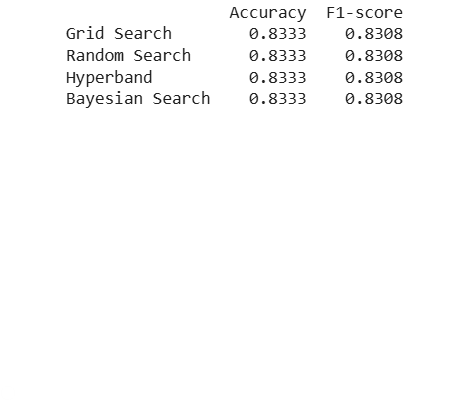